<a href="https://colab.research.google.com/github/thanhcong227/Machine-Learning/blob/master/Image_Classification_using_Softmax_Regression_and_Multi_class_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Softmax Regression and Multi-class Support Vector Machine

## Tải và giải nén dữ liệu

In [ ]:
!wget --no-clobber https://dl.dropboxusercontent.com/s/rtxgfuowr244irh/animals.zip

--2023-06-05 19:09:58--  https://dl.dropboxusercontent.com/s/rtxgfuowr244irh/animals.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93765293 (89M) [application/zip]
Saving to: ‘animals.zip’

animals.zip         100%[===================>]  89.42M  50.4MB/s    in 1.8s    

2023-06-05 19:10:01 (50.4 MB/s) - ‘animals.zip’ saved [93765293/93765293]



In [ ]:
import zipfile

# Unzip the archive
local_zip = './animals.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

## Liệt kê cấu trúc thư mục

In [ ]:
import os

base_dir = 'animals'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'train']

Contents of train directory:
['cats', 'chickens', 'dogs']

Contents of validation directory:
['cats', 'chickens', 'dogs']


In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_chickens_dir = os.path.join(train_dir, 'chickens')

# Directory with validation pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_chickens_dir = os.path.join(validation_dir, 'chickens')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
train_chicken_fnames = os.listdir(train_chickens_dir)

validation_cat_fnames = os.listdir(validation_cats_dir)
validation_dog_fnames = os.listdir(validation_dogs_dir)
validation_chicken_fnames = os.listdir(validation_chickens_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])
print(train_chicken_fnames[:10])

print('total training cat images :', len(train_cat_fnames))
print('total training dog images :', len(train_dog_fnames))
print('total training chicken images :', len(train_chicken_fnames))

print('total validation cat images :', len(validation_cat_fnames))
print('total validation dog images :', len(validation_dog_fnames))
print('total validation chicken images :', len(validation_chicken_fnames))

['cat.93.jpg', 'cat.815.jpg', 'cat.121.jpg', 'cat.592.jpg', 'cat.971.jpg', 'cat.413.jpg', 'cat.600.jpg', 'cat.826.jpg', 'cat.704.jpg', 'cat.168.jpg']
['dog.35.jpg', 'dog.584.jpg', 'dog.293.jpg', 'dog.678.jpg', 'dog.969.jpg', 'dog.76.jpg', 'dog.688.jpg', 'dog.273.jpg', 'dog.149.jpg', 'dog.214.jpg']
['OIP-8IL-IAkJ59DG8yzBZCEcAgHaFj.jpeg', '552.jpeg', '186.jpeg', 'OIP-5L1_hLwThlZ4L1SRAW_cGQAAAA.jpeg', 'OIP-2DJyMQtPudbkH28pc1PCowHaG7.jpeg', 'OIP-aDS5h-0Izcvx0eKmi9Mc-AHaEK.jpeg', 'OIP-4BjfBK_9WgxmyKbDmbNKLgHaFa.jpeg', 'OIP-2ywR9AepqtOD-JHXzBm_dAHaFj.jpeg', 'OIP-9V0T3M_6bEw5M7_OHQqpSgHaE9.jpeg', 'OIP-6QEYmPbMqTn_g0VFYu4tqAHaFj.jpeg']
total training cat images : 1000
total training dog images : 1000
total training chicken images : 1000
total validation cat images : 500
total validation dog images : 500
total validation chicken images : 500


## Hiển thị một số ảnh ví dụ

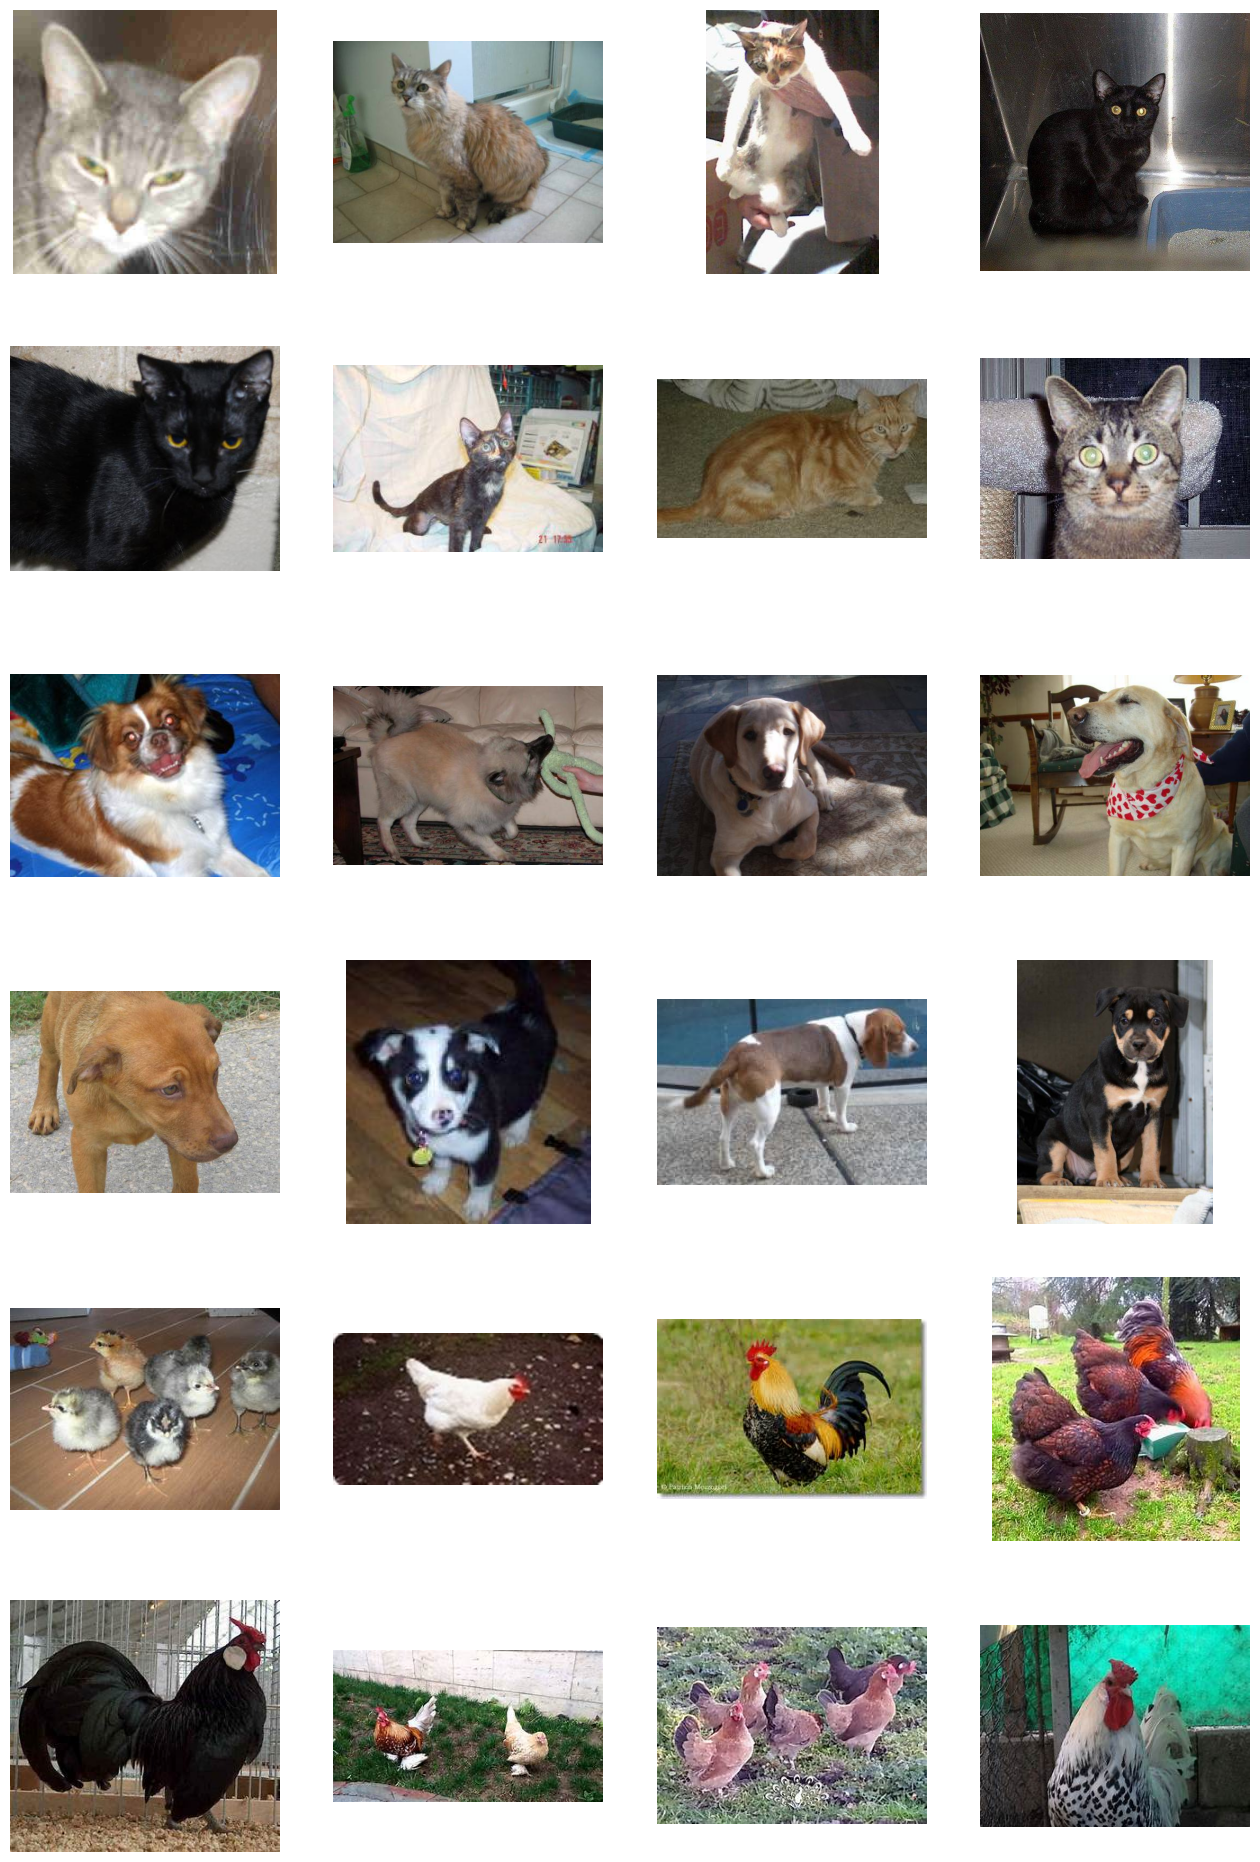

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 6x4 configuration
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[:8]
               ]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[:8]
               ]
next_chicken_pix = [os.path.join(train_chickens_dir, fname)
                for fname in train_chicken_fnames[:8]
               ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix + next_chicken_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

## Đọc và tiền xử lý dữ liệu

In [ ]:
image_size = 512  # tất cả ảnh được đưa về cùng kích thước 512x512

### Ảnh được đọc bằng thư viện OpenCV và tiền xử lý bằng phương pháp HOG (Histrogram of Oriented Gradient)

In [ ]:
import cv2
from tqdm import tqdm
from skimage.feature import hog

X_train = np.zeros((3000, int(image_size**2 / 32)))

train_cat_img_paths = [
    os.path.join(train_cats_dir, fname) for fname in train_cat_fnames
    ]
train_dog_img_paths = [
    os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames
    ]
train_chicken_img_paths = [
    os.path.join(train_chickens_dir, fname) for fname in train_chicken_fnames
    ]

count = 0

for img_path in tqdm(train_cat_img_paths + train_dog_img_paths + train_chicken_img_paths):
    img = cv2.resize(cv2.imread(img_path), (image_size, image_size))

    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), channel_axis=-1)

    X_train[count] = fd
    count += 1

y_train = np.array(1000 * ['cat'] + 1000 * ['dog'] + 1000 * ['chicken'])

100%|██████████| 3000/3000 [07:27<00:00,  6.70it/s]


In [ ]:
print(X_train.shape)
print(y_train.shape)

(3000, 8192)
(3000,)


In [ ]:
from tqdm import tqdm

X_test = np.zeros((1500, int(image_size**2 / 32)))

validation_cat_img_paths = [
    os.path.join(validation_cats_dir, fname) for fname in validation_cat_fnames
    ]
validation_dog_img_paths = [
    os.path.join(validation_dogs_dir, fname) for fname in validation_dog_fnames
    ]
validation_chicken_img_paths = [
    os.path.join(validation_chickens_dir, fname) for fname in validation_chicken_fnames
    ]

count = 0

for img_path in tqdm(validation_cat_img_paths + validation_dog_img_paths + validation_chicken_img_paths):
    img = cv2.resize(cv2.imread(img_path), (image_size, image_size))

    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), channel_axis=-1)

    X_test[count] = fd
    count += 1

y_test = np.array(500 * ['cat'] + 500 * ['dog'] + 500 * ['chicken'])

100%|██████████| 1500/1500 [03:39<00:00,  6.84it/s]


In [ ]:
print(X_test.shape)
print(y_test.shape)

(1500, 8192)
(1500,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)

y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

### Minh họa kết quả của HOG

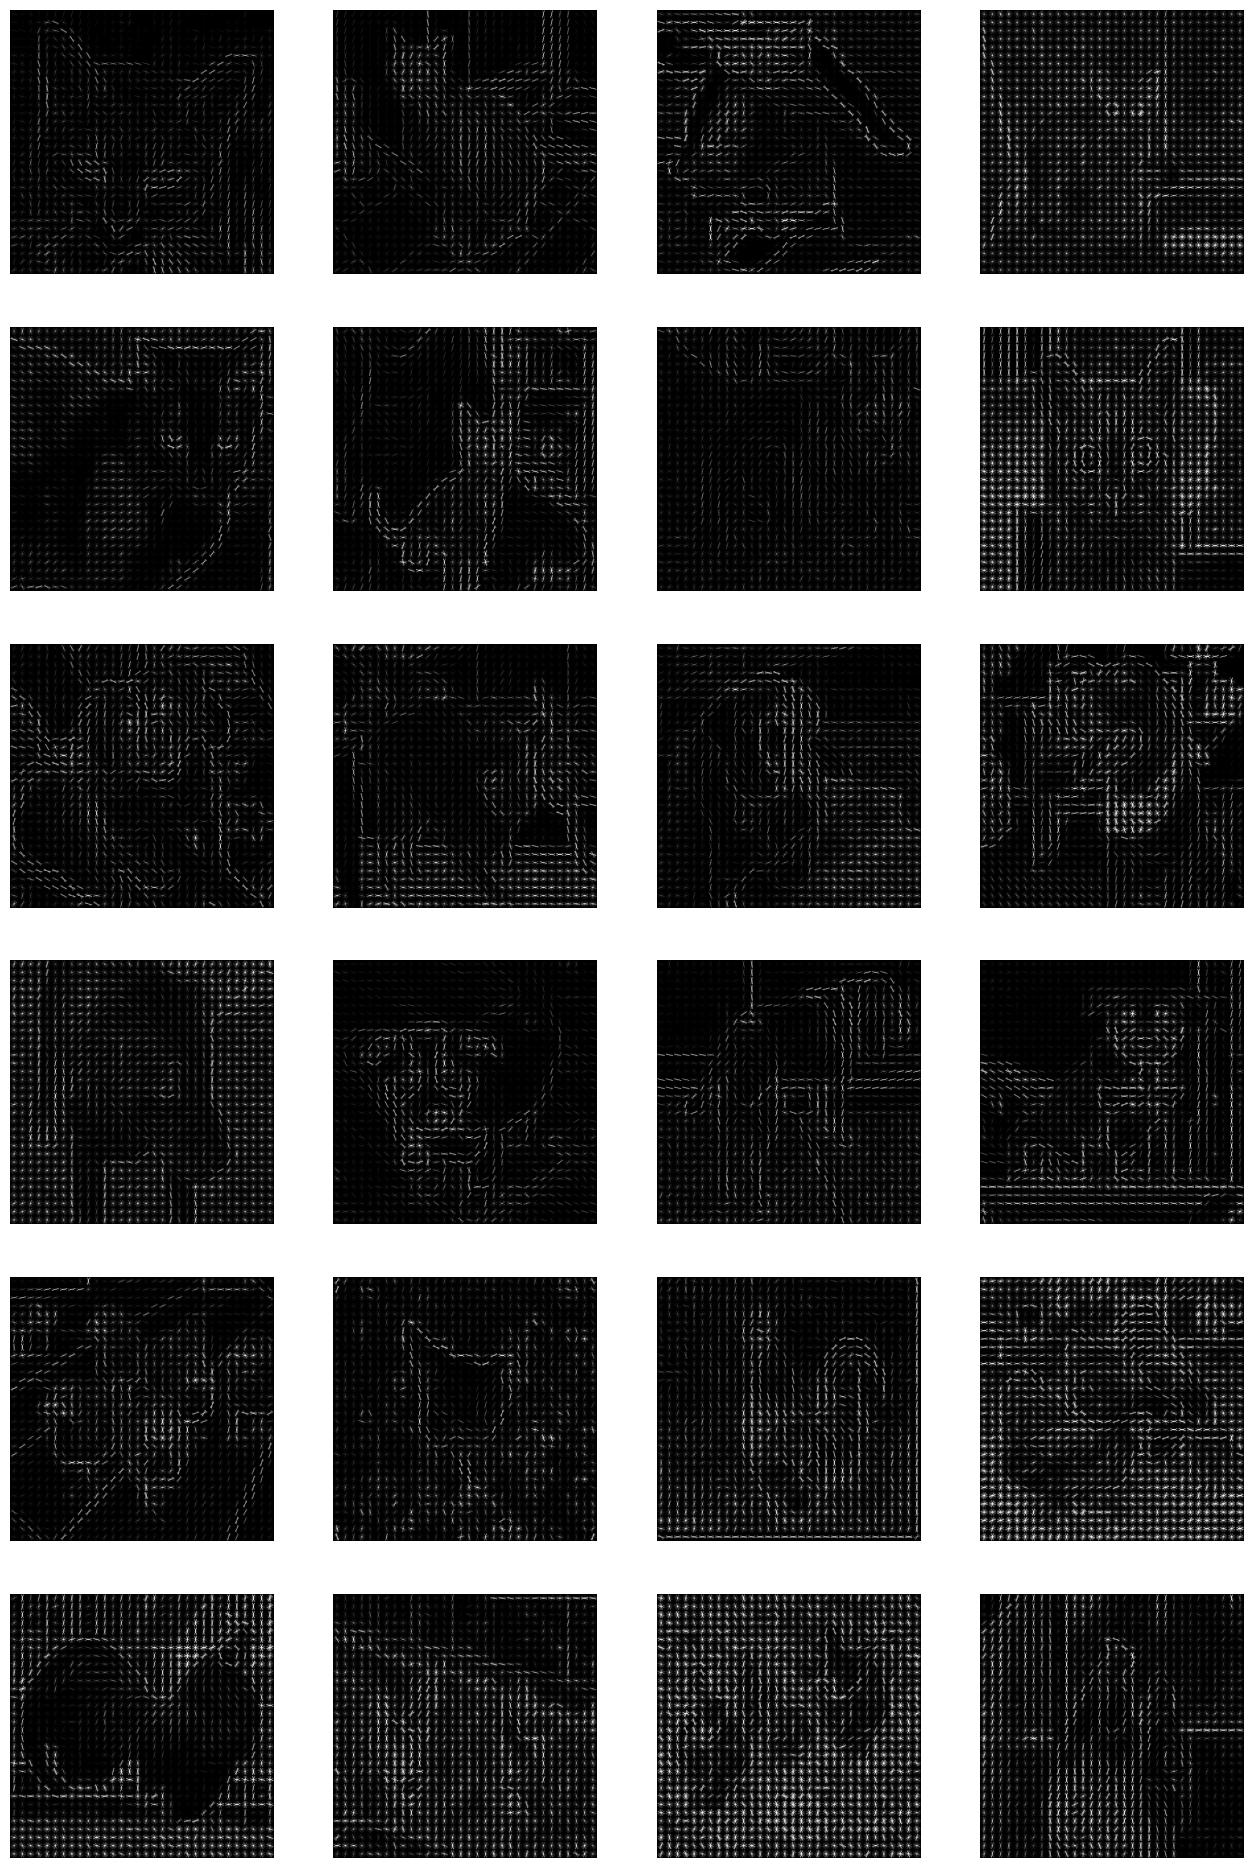

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

# Parameters for our graph; we'll output images in a 6x4 configuration
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[:8]
               ]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[:8]
               ]
next_chicken_pix = [os.path.join(train_chickens_dir, fname)
                for fname in train_chicken_fnames[:8]
               ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix + next_chicken_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = cv2.resize(cv2.imread(img_path), (image_size, image_size))

    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

plt.show()

## Giảm chiều và minh họa dữ liệu

### Sử dụng PCA (Principal component analysis)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

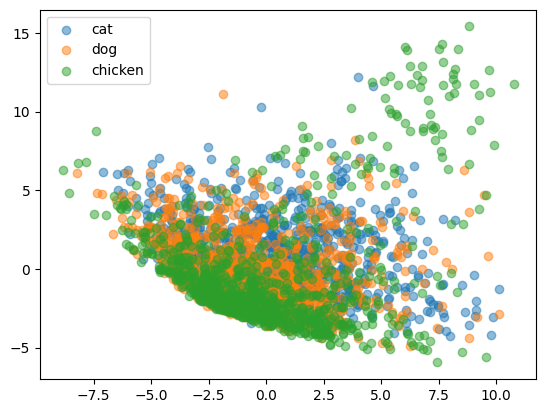

In [ ]:
import matplotlib.pyplot as plt

x = X_train_pca[:, 0]
y = X_train_pca[:, 1]
z = X_train_pca[:, 2]

plt.scatter(x[:1000], y[:1000], label='cat', alpha=0.5)
plt.scatter(x[1000:2000], y[1000:2000], label='dog', alpha=0.5)
plt.scatter(x[2000:], y[2000:], label='chicken', alpha=0.5)

plt.legend()

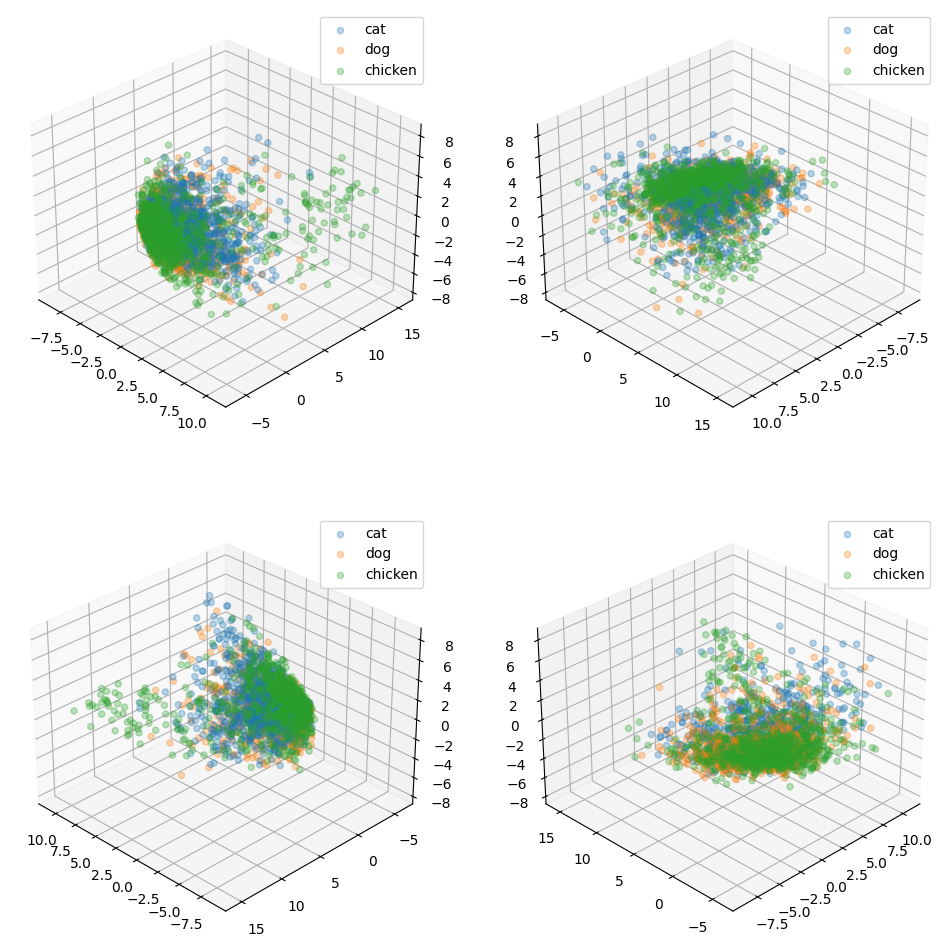

In [ ]:
fig = plt.figure(figsize=(12, 12))

for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')

    ax.scatter(x[:1000], y[:1000], z[:1000], label='cat', alpha=0.3)
    ax.scatter(x[1000:2000], y[1000:2000], z[1000:2000], label='dog', alpha=0.3)
    ax.scatter(x[2000:], y[2000:], z[2000:], label='chicken', alpha=0.3)

    ax.view_init(azim=-45 + 90 * i)

    ax.legend()

**Nhận xét**: Dữ liệu không phân tách được sử dụng phương pháp PCA.

### Sử dụng LDA (Linear discriminant analysis)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(X_train, y_train)

X_lda = lda.transform(X_train)

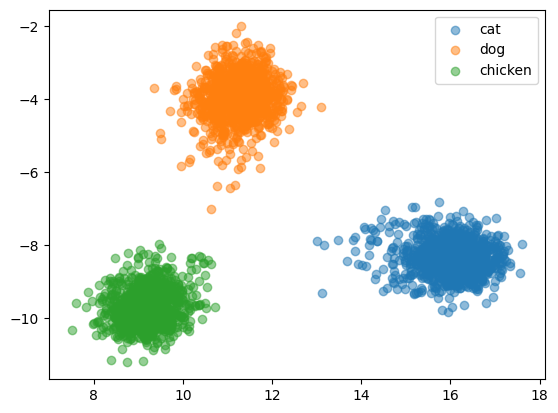

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = X_lda[:, 0]
y = X_lda[:, 1]

plt.scatter(x[:1000], y[:1000], label='cat', alpha=0.5)
plt.scatter(x[1000:2000], y[1000:2000], label='dog', alpha=0.5)
plt.scatter(x[2000:], y[2000:], label='chicken', alpha=0.5)

plt.legend()

In [ ]:
X_lda = lda.transform(X_test)

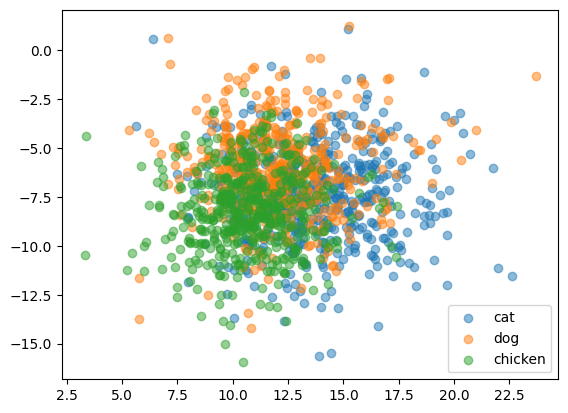

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = X_lda[:, 0]
y = X_lda[:, 1]

plt.scatter(x[:500], y[:500], label='cat', alpha=0.5)
plt.scatter(x[500:1000], y[500:1000], label='dog', alpha=0.5)
plt.scatter(x[1000:], y[1000:], label='chicken', alpha=0.5)

plt.legend()

plt.show()

**Nhận xét**: Phương pháp LDA có thể tách được dữ liệu train nhưng bị overfit và không phân tách được dữ liệu validation.

## Phân cụm dữ liệu

### Sử dụng K-means clustering

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
        set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

In [ ]:
(centers, labels, it) = kmeans(X_train, K = 3)
print('Centers found by our algorithm:')
print(centers[-1])

Centers found by our algorithm:
[[0.3711524  0.24465486 0.32975206 ... 0.30484633 0.31982396 0.26165407]
 [0.43367722 0.29203787 0.30190253 ... 0.28369721 0.34880855 0.33908904]
 [0.37324407 0.14145054 0.23139097 ... 0.14976504 0.25785119 0.17448337]]


### Đếm số lượng điểm dữ liệu được phân vào mỗi cluster

In [ ]:
unique, counts = np.unique(labels[-1], return_counts=True)

np.asarray((unique, counts))

array([[   0,    1,    2],
       [1093, 1566,  341]])

#### Số lượng mèo được phân vào mỗi cluster

In [ ]:
unique, counts = np.unique(labels[-1][:1000], return_counts=True)

np.asarray((unique, counts))

array([[  0,   1,   2],
       [385, 466, 149]])

#### Số lượng chó được phân vào mỗi cluster

In [ ]:
unique, counts = np.unique(labels[-1][1000:2000], return_counts=True)

np.asarray((unique, counts))

array([[  0,   1,   2],
       [417, 507,  76]])

#### Số lượng gà được phân vào mỗi cluster

In [ ]:
unique, counts = np.unique(labels[-1][2000:], return_counts=True)

np.asarray((unique, counts))

array([[  0,   1,   2],
       [291, 593, 116]])

### Minh họa

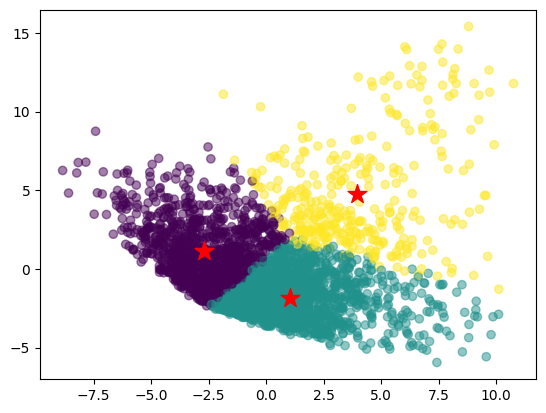

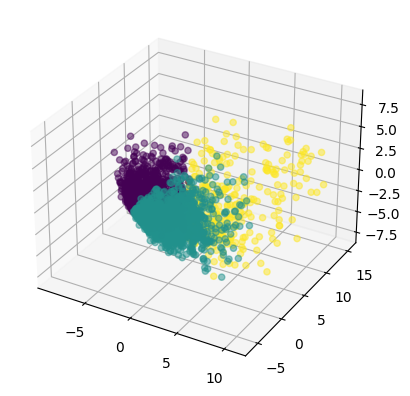

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = X_train_pca[:, 0]
y = X_train_pca[:, 1]
z = X_train_pca[:, 2]

plt.scatter(x, y, c=labels[-1], alpha=0.5)

cluster_centers = pca.transform(centers[-1])
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='*', s=200, color='red')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=labels[-1], alpha=0.5)

plt.show()

## Phân loại bằng Softmax Regression

In [ ]:
from scipy import sparse

C = 3

def convert_labels(y, C = C):
    """
    convert 1d label to a matrix label: each column of this
    matrix coresponding to 1 element in y. In i-th column of Y,
    only one non-zeros element located in the y[i]-th position,
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return
            [[1, 0, 0, 1],
            [0, 0, 1, 0],
            [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

# Y = convert_labels(y, C)

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    """
    #Compute softmax values for each sets of scores in V.
    #each column of V is a set of score.
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count%check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

# cost or loss function
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

# Predict that X belong to which class (1..C now indexed as 0..C-1 )
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [ ]:
eta = .05
d = X_train.shape[1]
W_init = np.random.randn(d, C)
W = softmax_regression(X_train.T, y_train_encoded, W_init, eta, max_count=10000000)
print(W[-1])

[[ 0.7763014  -0.58529642  0.08450083]
 [-0.84568406  2.85590981 -0.96747141]
 [-2.49255384  1.4364392  -0.63319918]
 ...
 [-0.87099052  1.58710166  1.79312789]
 [-0.0144531  -2.03018627  1.44257694]
 [ 2.64752045  0.23345619 -1.4325999 ]]


In [ ]:
y_train_pred = pred(W[-1], X_train.T)
y_pred = pred(W[-1], X_test.T)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

def evaluate(y_train, y_train_pred, y_test, y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_train, y_train_pred)
    print("Train accuracy:", accuracy)

    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy:", accuracy)

    # Calculate the precision of each class
    precision = precision_score(y_test, y_pred, average=None)

    # Print the precision of each class
    print("Precision of each class:", precision)

    # Calculate the recall of each class
    recall = recall_score(y_test, y_pred, average=None)

    # Print the recall of each class
    print("Recall of each class:", recall)

    # Print confusion matrix
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))

In [ ]:
evaluate(y_train_encoded, y_train_pred, y_test_encoded, y_pred)

Train accuracy: 0.7723333333333333
Test accuracy: 0.5766666666666667
Precision of each class: [0.52173913 0.81860465 0.55864811]
Recall of each class: [0.816 0.352 0.562]
Confusion matrix:
[[408   9  83]
 [185 176 139]
 [189  30 281]]


### So sánh với scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial',
                            solver='saga',
                            max_iter=10000,
                            random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [ ]:
# Use the trained model to predict the classes of the test set
y_train_pred = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [ ]:
evaluate(y_train, y_train_pred, y_test, y_pred)

Train accuracy: 1.0
Test accuracy: 0.646
Precision of each class: [0.64587525 0.70182556 0.59215686]
Recall of each class: [0.642 0.692 0.604]
Confusion matrix:
[[321  62 117]
 [ 63 346  91]
 [113  85 302]]


## Phân loại bằng Multi-class Support Vector Machine

In [ ]:
# method to compute loss function and its gradient
# here vectorization was used to speed up
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape
    _, N = X.shape
    loss = 0
    dW = np.zeros_like(W)

    Z = W.T.dot(X)

    correct_class_score = np.choose(y, Z).reshape(N,1).T
    margins = np.maximum(0, Z - correct_class_score + 1)
    margins[y, np.arange(margins.shape[1])] = 0
    # Loss function
    loss = np.sum(margins, axis = (0, 1))
    loss /= N
    loss += 0.5 * reg * np.sum(W * W)

    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
    # Gradient
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

In [ ]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1,
                      batch_size = 100, num_iters = 10000, print_every = 1000):
    W = Winit
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)

        W -= lr*dW
        if it % print_every == 1:
            print ('it %d/%d, loss = %f' %(it, num_iters, loss_history[it]))

    return W, loss_history

it 1/10000, loss = 34.716303
it 1001/10000, loss = 11.049939
it 2001/10000, loss = 17.226798
it 3001/10000, loss = 6.334276
it 4001/10000, loss = 3.527330
it 5001/10000, loss = 12.291692
it 6001/10000, loss = 1.849256
it 7001/10000, loss = 1.531472
it 8001/10000, loss = 1.527235
it 9001/10000, loss = 12.443821


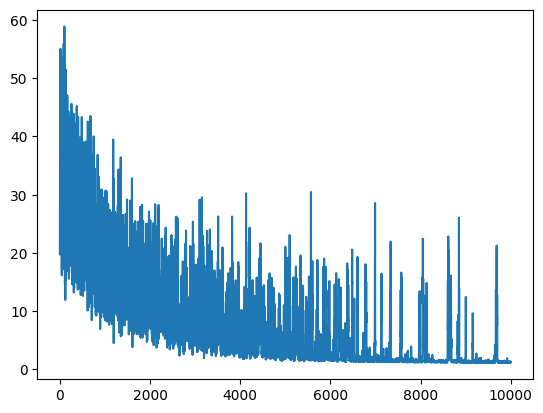

In [ ]:
C = 3
d = X_train.shape[1]
reg = 0.0001
W = np.random.randn(d, C)

W, loss_history = multiclass_svm_GD(X_train.T, y_train_encoded, W, reg)

import matplotlib.pyplot as plt
# plot loss as a function of iteration
plt.plot(loss_history)
plt.show()

In [ ]:
y_train_pred = np.argmax(X_train.dot(W), axis=1)
y_pred = np.argmax(X_test.dot(W), axis=1)

In [ ]:
evaluate(y_train_encoded, y_train_pred, y_test_encoded, y_pred)

Train accuracy: 0.983
Test accuracy: 0.5966666666666667
Precision of each class: [0.58287796 0.63333333 0.57142857]
Recall of each class: [0.64  0.646 0.504]
Confusion matrix:
[[320  81  99]
 [ 87 323  90]
 [142 106 252]]


### So sánh với scikit-learn

#### Linear kernel

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier with a linear kernel
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Use the trained model to predict the classes of the test set
y_train_pred = svm.predict(X_train)
y_pred = svm.predict(X_test)

In [ ]:
evaluate(y_train, y_train_pred, y_test, y_pred)

Train accuracy: 1.0
Test accuracy: 0.622
Precision of each class: [0.61026616 0.68723404 0.5734127 ]
Recall of each class: [0.642 0.646 0.578]
Confusion matrix:
[[321  62 117]
 [ 79 323  98]
 [126  85 289]]


#### Sigmoid kernel

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier with a sigmoid kernel
svm = SVC(kernel='sigmoid', gamma='auto')
svm.fit(X_train, y_train)

SVC(gamma='auto', kernel='sigmoid')

In [ ]:
# Use the trained model to predict the classes of the test set
y_train_pred = svm.predict(X_train)
y_pred = svm.predict(X_test)

In [ ]:
evaluate(y_train, y_train_pred, y_test, y_pred)

Train accuracy: 0.48
Test accuracy: 0.456
Precision of each class: [0.60189573 0.51       0.39707537]
Recall of each class: [0.254 0.408 0.706]
Confusion matrix:
[[127  90 283]
 [ 43 204 253]
 [ 41 106 353]]


#### Radial Basic Function (RBF) kernel

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier with a rbf kernel
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

In [ ]:
# Use the trained model to predict the classes of the test set
y_train_pred = svm.predict(X_train)
y_pred = svm.predict(X_test)

In [ ]:
evaluate(y_train, y_train_pred, y_test, y_pred)

Train accuracy: 0.9496666666666667
Test accuracy: 0.6573333333333333
Precision of each class: [0.64098074 0.72258065 0.61206897]
Recall of each class: [0.732 0.672 0.568]
Confusion matrix:
[[366  39  95]
 [ 79 336  85]
 [126  90 284]]


#### Poly kernel

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier with a poly kernel
svm = SVC(kernel='poly')
svm.fit(X_train, y_train)

SVC(kernel='poly')

In [ ]:
# Use the trained model to predict the classes of the test set
y_train_pred = svm.predict(X_train)
y_pred = svm.predict(X_test)

In [ ]:
evaluate(y_train, y_train_pred, y_test, y_pred)

Train accuracy: 1.0
Test accuracy: 0.642
Precision of each class: [0.64023211 0.71762208 0.57421875]
Recall of each class: [0.662 0.676 0.588]
Confusion matrix:
[[331  47 122]
 [ 66 338  96]
 [120  86 294]]
